In [ ]:
!pip install --upgrade diffusers[torch] transformers openai evotorch compel

## ログ等保存用にgoogle driveと接続


In [ ]:
from google.colab import drive
drive.mount('/gdrive')

In [ ]:
fetish_path = "/path/to/fetish/"

## フェチモデル関連

In [ ]:
def generate_fetish_seed(dim=16, device="cuda", dtype=torch.float16):
    return torch.randn((dim), device=device, dtype=dtype)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FetishSeedToTensorModel(nn.Module):
    def __init__(self, checkpoint = None, **kwargs):
        super().__init__(**kwargs)

        # 1D Convolutional layers
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1, device='cuda', dtype=torch.float16)
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1, device='cuda', dtype=torch.float16)
        self.conv3 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1, device='cuda', dtype=torch.float16)
        self.conv4 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1, device='cuda', dtype=torch.float16)
        self.conv5 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1, device='cuda', dtype=torch.float16)

        # Pooling layer
        self.pool = nn.AdaptiveAvgPool1d(2)

        # Fully connected layers
        self.fc1 = nn.Linear(256 * 2, 1024, device='cuda', dtype=torch.float16)
        self.fc2 = nn.Linear(1024, 77*1024, device='cuda', dtype=torch.float16)

        if checkpoint is not None:
            self.load_state_dict(checkpoint['model_state_dict'])

    def forward(self, x):
        # Reshape input to (batch_size, channels, length)
        x = x.view(-1, 1, 16).to(torch.float16)

        # Convolutional layers with ReLU activation
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))

        # Pooling
        x = self.pool(x)

        # Flatten
        x = x.view(x.size(0), -1)

        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        # Apply Tanh activation and scale to -0.2 to 0.2
        x = torch.tanh(x) * 0.2

        # Reshape output to (batch_size, 77, 1024)
        x = x.view(-1, 77, 1024)

        return x

class FetishSeedToTensor():
  def __init__(self):
    self._fetish_seed = generate_fetish_seed()
    self._fetish_model = FetishSeedToTensorModel().to("cuda").to(torch.float16)

  @property
  def fetish_seed(self):
    return self._fetish_seed

  @fetish_seed.setter
  def fetish_seed(self, value):
    self._fetish_seed = value

  @property
  def fetish_model(self):
    return self._fetish_model

  @fetish_model.setter
  def fetish_model(self, value):
    self._fetish_model = value

  def __call__(self):
    return self._fetish_model(self._fetish_seed)

In [ ]:
fetish_seed_to_tensor = FetishSeedToTensor()

In [ ]:
from transformers import CLIPTextModel
from typing import Any, Optional, Tuple, Union
from transformers.modeling_outputs import BaseModelOutputWithPooling
import torch
from transformers.models.clip.configuration_clip import CLIPTextConfig


class FetishTextModel(CLIPTextModel):
  def __init__(self, config: CLIPTextConfig, fetish_seed_to_tensor: FetishSeedToTensor):
    super().__init__(config)
    self._fetish_seed_to_tensor = fetish_seed_to_tensor

  def forward(
        self,
        input_ids: Optional[torch.Tensor] = None,
        attention_mask: Optional[torch.Tensor] = None,
        position_ids: Optional[torch.Tensor] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        return_dict: Optional[bool] = None,
        **kwargs
    ) -> Union[Tuple, BaseModelOutputWithPooling]:
    outputs = super().forward(
        input_ids=input_ids,
        attention_mask=attention_mask,
        position_ids=position_ids,
        output_attentions=output_attentions,
        output_hidden_states=output_hidden_states,
        return_dict=return_dict,
        **kwargs
    )
    fetish_output = self._fetish_seed_to_tensor().to("cuda").to(torch.float16)
    modified_last_hidden_state = outputs.last_hidden_state + fetish_output

    # 加算後のlast_hidden_stateを使って新しいBaseModelOutputWithPoolingオブジェクトを作成
    modified_outputs = BaseModelOutputWithPooling(
        last_hidden_state=modified_last_hidden_state,
        pooler_output=outputs.pooler_output,
        hidden_states=outputs.hidden_states,
        attentions=outputs.attentions,
    )
    # 新しいオブジェクトを返す
    return modified_outputs



## GPT4-V

In [ ]:
import base64

from openai import OpenAI
from google.colab import userdata
import numpy as np
import io


# 画像をbase64にエンコードする関数
def encode_image(image):
  # PILの画像データをバイトデータに変換
  buffer = io.BytesIO()
  image.save(buffer, format="PNG")
  img_bytes = buffer.getvalue()

  # バイトデータをbase64エンコード
  img_base64 = base64.b64encode(img_bytes)
  return img_base64.decode("utf-8")


# OpenAI APIのクライアントを作成する.
# Google Colaobratory のシークレットを使ってAPI KEYを指定する
client = OpenAI(
    api_key=userdata.get('OPENAI_API_KEY'),
)

def evaluate_image(image):
  base64_image = encode_image(image)
  # チャットの応答を生成する
  response = client.chat.completions.create(
      # model の名前は gpt-4-vision-preview.
      model="gpt-4-vision-preview",
      messages=[
          {
            "role": "system",
            "content": """
You are about to work on a simulation that mirrors human development, focusing on the process of acquiring a fetish for illustration as a teenager. Your assignment consists of four main activities centered around exploring and defining your own preferences for illustrations.
Here's what you will do:

1. evaluate the illustrations on a 100-point scale based on your personal fascination vector. The evaluation should be rigorous, and high scores (50 or more) should be modest to truly resonate with your personal preferences, but high scores should be given to items that strongly align with your own preferences.
2. reflect on and discuss your fascination as inferred from the evaluations you have made
3. convert your fascinationes from the discussion into a 16-dimensional vector.
4. export the ratings and fascination vectors to JSON format for processing.


Please find the template below for the output:
　　　　{
  　　　　"evaluate": int,  // Evaluation score ranging from 0 to 100. Note that the evaluation should be rigorous, and high scores (50 or more) should be modest to truly resonate with your personal preferences, but high scores should be given to items that strongly align with your own preferences.
  　　　　"fascination_vector": [float] // A 16-dimensional array representing your fascination
　　　　}
Ensure the output is strictly in JSON format without any additional comments or information.
"""
          },
          {
              "role": "user",
              "content": [
                  {"type": "text", "text": str(fetish_seed_to_tensor.fetish_seed.to('cpu').detach().numpy().copy().tolist())}, 
                  {"type": "image_url", "image_url": f"data:image/jpeg;base64,{base64_image}"}, 
              ],
          }
      ],
      max_tokens=300,
  )

  return response.choices[0].message.content


## StableDiffustion初期化

In [ ]:
from diffusers import StableDiffusionPipeline, EulerDiscreteScheduler
import torch

# パイプラインの準備
model_id = "stabilityai/stable-diffusion-2-1"
pipe = StableDiffusionPipeline.from_pretrained(
    model_id,
    scheduler=EulerDiscreteScheduler.from_pretrained(
        model_id,
        subfolder="scheduler"
    ),
    torch_dtype=torch.float16,
    text_encoder=FetishTextModel.from_pretrained(
        model_id,
        subfolder="text_encoder",
        torch_dtype=torch.float16,
        fetish_seed_to_tensor=fetish_seed_to_tensor,
        ),
    custom_pipeline="lpw_stable_diffusion",
).to("cuda")
pipe.enable_attention_slicing()

## 進化計算

In [ ]:
def remove_json_blocks(text):
    # 文字列内の ```json と ``` のペアを見つけて削除する
    import re
    # 正規表現パターン: ```json から始まり、任意の文字列、そして ``` で終わる部分を探す
    pattern = re.compile(r'```json\n?|```')
    # パターンに一致する部分を空文字列で置換（削除）
    cleaned_text = re.sub(pattern, '', text)
    return cleaned_text

In [ ]:
POP_SIZE = 8
MAX_GENERATIONS = 50
MAX_CHARA_TRAIN_NUM = 4

chara_prompt = "A princess of a water country, with long silver hair, wearing a transparent blue dress."

In [ ]:
import torch
from evotorch.tools import dtype_of, device_of
from pydantic import BaseModel, ValidationError

i = 0
j = 0
gen = 0
error_count = 0
max_evaluate = 0

class EvaluateLog(BaseModel):
    evaluate: float
    chara_idx: int

class GenerationLog(BaseModel):
    gen: int
    evaluates: list[EvaluateLog]

class TrainLog(BaseModel):
    generations: list[GenerationLog]

class EvaluateResponse(BaseModel) :
  evaluate : int
  fascination_vector : list

generation_log = GenerationLog(gen=0, evaluates=[])
train_log = TrainLog(generations=[generation_log])

def network_eval_func(network: torch.nn.Module):
    # global変数を使いたくないが動かすことを優先した
    global i, j gen, error_count, max_evaluate
    global train_log, generation_log
    # network: FetishSeedToTensorModel
    # networkはFetishTextModelでも使う。
    # global宣言しているfetish_seed_to_tensorを皆が共有しているので、そこへ通知
    fetish_seed_to_tensor.fetish_model = network
    image = pipe(chara_prompt+" Japanese anime-style illustration.", height=768, width=768, max_embeddings_multiples=3).images[0]

    try :
        evaluate_raw = evaluate_image(image)
        evaluate_response = EvaluateResponse.parse_raw(remove_json_blocks(evaluate_raw))
        evaluate = evaluate_response.evaluate
        if max_evaluate <= evaluate:
            max_evaluate = evaluate
            if len(evaluate_response.fascination_vector) == 16:
              fetish_seed_to_tensor.fetish_seed = torch.tensor(evaluate_response.fascination_vector, device=torch.device('cuda'), dtype=torch.float16)

    except (ValidationError, Exception) as e:
      error_count += 1
      print("parse error")
      print(f"error_count : {error_count}, {e}")
      # 一旦エラー時は評価0とする
      evaluate = 0

    finally:
      #　i: pop数に該当
      # j: そのキャラで何回目の学習か
      i += 1
      if i > POP_SIZE-1:
          gen += 1
          generation_log = GenerationLog(gen=gen, evaluates=[])
          train_log.generations.append(generation_log)
          i = 0
          j += 1



    print(f"第{gen}世代 第{j}回目学習 第{i}population：{evaluate}")

    evaluate_log = EvaluateLog(evaluate=evaluate, chara_idx=j)
    generation_log.evaluates.append(evaluate_log)

    return evaluate

In [ ]:
from evotorch.logging import Logger
import torch
import os

class TorchSaveLogger(Logger):
    def __init__(self, searcher, problem, fetish_seed_to_tensor):
        super().__init__(searcher)
        self.problem = problem
        self.fetish_seed_to_tensor = fetish_seed_to_tensor

    def _log(self, status: dict):
        print(status.keys())
        if "pop_best" not in status.keys():
          return

        net = self.problem.parameterize_net(status["pop_best"])

        checkpoint_path = os.path.join(fetish_path,"checkpoint.pt")

        torch.save(
            {
                'model_state_dict': net.state_dict(),
                "fetish_seed": self.fetish_seed_to_tensor.fetish_seed,
            },
            checkpoint_path
        )
        torch.cuda.empty_cache()


In [ ]:
from evotorch.neuroevolution import NEProblem

checkpoint_path = os.path.join(fetish_path,"checkpoint.pt")
if os.path.exists(checkpoint_path):
  checkpoint = torch.load(checkpoint_path)
  fetish_seed_to_tensor.fetish_seed = checkpoint["fetish_seed"]
else:
  checkpoint = None

problem = NEProblem(
    objective_sense="max",
    network=FetishSeedToTensorModel,
    network_args={"checkpoint": checkpoint},
    network_eval_func=network_eval_func,
    device=torch.device('cuda'),
    eval_dtype=torch.float16,
)

In [ ]:
from evotorch.algorithms import PGPE

searcher = PGPE(
    problem,
    popsize=POP_SIZE,
    radius_init=2.25,
    center_learning_rate=0.2,
    stdev_learning_rate=0.1,
)
logger = TorchSaveLogger(searcher, problem, fetish_seed_to_tensor)
searcher.run(MAX_GENERATIONS)

In [ ]:
# prompt: jsonファイルを保存する

import json
import datetime
now = datetime.datetime.now(datetime.timezone(datetime.timedelta(hours=9)))

with open(os.path.join(fetish_path, f"train_log-{now.strftime('%Y%m%d%H%M')}.json"),'w') as f:
  f.write(train_log.model_dump_json(indent=2))


In [ ]:
from pydantic import ValidationError
try:
  EvaluateResponse.parse_raw("{}")
except ValidationError as e:
  print(e)

# 解析

In [ ]:
!ls -l {fetish_path} | grep json


In [ ]:
import os

time = "xxxxx"

with open(os.path.join(fetish_path, f"train_log-{time}.json"), 'r') as f:
  train_log = TrainLog.parse_raw(f.read())


In [ ]:
for generation in train_log.generations:
    original_evaluates_len = len(generation.evaluates)
    generation.evaluates = [evaluate for evaluate in generation.evaluates if evaluate.evaluate != 0]
    if len(generation.evaluates) < original_evaluates_len:
        print(f"removed {original_evaluates_len - len(generation.evaluates)} evaluates")


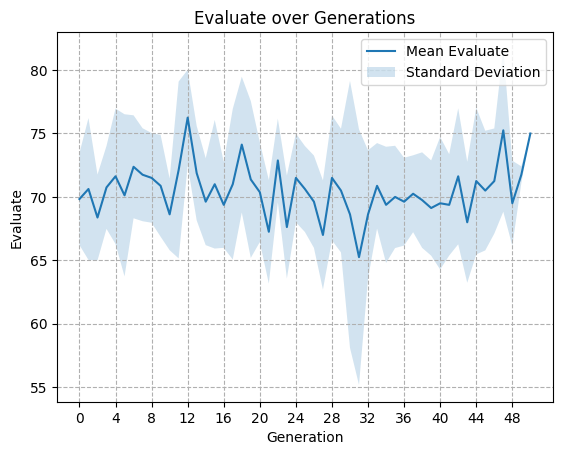

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Extract the evaluate values for each generation
evaluates = [evaluate.evaluate for generation in train_log.generations for evaluate in generation.evaluates]

# Calculate the mean and standard deviation of the evaluates for each generation
means = []
stds = []
for generation in train_log.generations:
    generation_evaluates = [evaluate.evaluate for evaluate in generation.evaluates]
    means.append(np.mean(generation_evaluates))
    stds.append(np.std(generation_evaluates))

# Plot the mean and standard deviation of the evaluates for each generation
plt.plot(range(len(train_log.generations)), means, label="Mean Evaluate")
plt.fill_between(range(len(train_log.generations)), np.array(means) - np.array(stds), np.array(means) + np.array(stds), alpha=0.2, label="Standard Deviation")

# Set the x-axis label, y-axis label, and title
plt.xlabel("Generation")
plt.ylabel("Evaluate")
plt.title("Evaluate over Generations")

# Set the x-axis ticks to be every 4 generations
plt.xticks(range(0, len(train_log.generations), 4))

# Add a grid to the plot
plt.grid(linestyle="--")

# Show the legend
plt.legend()

# Display the plot
plt.show()


In [ ]:
import numpy as np
from sklearn.linear_model import LinearRegression

# Extract the evaluate values for each generation
evaluates = [evaluate.evaluate for generation in train_log.generations for evaluate in generation.evaluates]

# Calculate the mean and standard deviation of the evaluates for each generation
means = []
stds = []
for generation in train_log.generations:
    generation_evaluates = [evaluate.evaluate for evaluate in generation.evaluates]
    means.append(np.mean(generation_evaluates))
    stds.append(np.std(generation_evaluates))

# Reshape the generation numbers and means for linear regression
generations = np.array(range(len(train_log.generations))).reshape(-1, 1)
means = np.array(means).reshape(-1, 1)
stds = np.array(stds).reshape(-1, 1)

# Fit a linear regression model to the data
mean_model = LinearRegression()
mean_model.fit(generations, means)

# Get the slope of the regression line
mean_slope = mean_model.coef_[0][0]

# Print the mean_slope
print("mean_slope:", mean_slope)


# Fit a linear regression model to the data
std_model = LinearRegression()
std_model.fit(generations, stds)

# Get the slope of the regression line
std_slope = std_model.coef_[0][0]

# Print the std_slope
print("std_slope:", std_slope)

mean_slope: -0.004724736048265449
std_slope: -0.008139173459992094


# 定性評価

In [ ]:
checkpoint_path = os.path.join(fetish_path,"checkpoint.pt")
checkpoint = torch.load(checkpoint_path)
fetish_seed_to_tensor.fetish_seed = checkpoint["fetish_seed"]

model = FetishSeedToTensorModel(checkpoint)
fetish_seed_to_tensor.fetish_model = model
images = pipe(chara_prompt+" Japanese anime-style illustration.", height=768, width=768, num_images_per_prompt=10).images

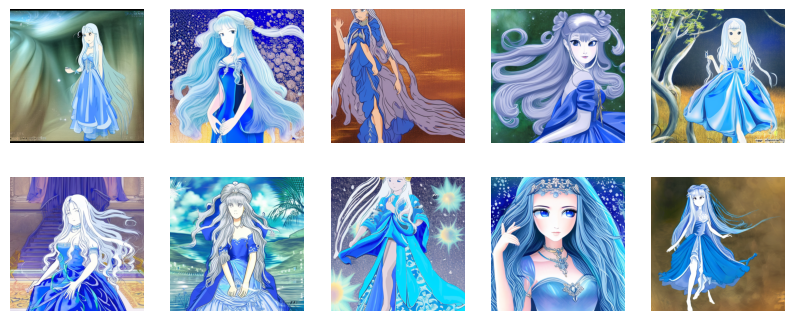

In [ ]:
import matplotlib.pyplot as plt

# Create a figure and axes
fig, axs = plt.subplots(2, 5, figsize=(10, 4))

# Iterate over the images and display them
for i, image in enumerate(images):
    row = i // 5
    col = i % 5
    axs[row, col].imshow(image)
    axs[row, col].axis('off')

# Show the plot
plt.show()
